In [1]:
import os
import copy
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

In [2]:
# Configuración general
folder_path = r"/home/alkain/Escritorio/Github_Repositorios/Microgrid/TrainTestSplit"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Función para cargar y preprocesar datos (usada tanto para entrenamiento como para test)
def load_and_preprocess(files, all_sources):
    df_list = []
    for file in files:
        file_path = os.path.join(folder_path, file)
        df = pd.read_csv(file_path, parse_dates=["Time Stamp (local standard time) yyyy-mm-ddThh:mm:ss"])
        df = df.drop(columns='Time Stamp (local standard time) yyyy-mm-ddThh:mm:ss')
        # Muestreo estratificado
        df_sampled = df.groupby('source', group_keys=False).apply(lambda x: x.sample(frac=0.4, random_state=42))
        df_list.append(df_sampled)
    full_df = pd.concat(df_list, ignore_index=True)
    
    # One-hot encoding con categorías fijas
    full_df['source'] = pd.Categorical(full_df['source'], categories=all_sources)
    full_df = pd.get_dummies(full_df, columns=['source'], prefix='src', dtype=np.float32)
    
    return full_df


In [4]:
# Función para preparar tensores a partir de DataFrame
def prepare_data(df, scaler=None):
    # Separar características y target
    X = df.drop(columns=['Pmp (W)']).values.astype(np.float32)
    y = df['Pmp (W)'].values.astype(np.float32)
    if scaler is None:
        scaler = StandardScaler()
        X = scaler.fit_transform(X)
    else:
        X = scaler.transform(X)
    X_tensor = torch.tensor(X).to(device)
    y_tensor = torch.tensor(y).unsqueeze(1).to(device)
    return X_tensor, y_tensor, scaler

In [5]:
# Definición del modelo
class EnhancedDNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        
    def forward(self, x):
        return self.model(x)

In [6]:
# Parámetros del Federated Learning
federated_rounds = 5         # número de rondas federadas
local_epochs = 40             # épocas locales por cada ronda
batch_size = 512
lr = 0.0001
weight_decay = 1e-4

In [7]:
# Definir los clientes y sus archivos de entrenamiento
clients = {
    "cocoa": [f for f in os.listdir(folder_path) if f.endswith('.csv') and "train" in f and "cocoa" in f.lower()],
    "eugene": [f for f in os.listdir(folder_path) if f.endswith('.csv') and "train" in f and "eugene" in f.lower()],
    "golden": [f for f in os.listdir(folder_path) if f.endswith('.csv') and "train" in f and "golden" in f.lower()]
}

# Para test, se puede hacer lo mismo (o unir todos los test en uno solo)
test_files = [f for f in os.listdir(folder_path) if f.endswith('.csv') and "test" in f]


In [8]:
# Antes de cualquier preprocesamiento, recolectar TODAS las categorías posibles de 'source'
all_sources = set()

# Recolectar de los clientes
for client_files in clients.values():
    for file in client_files:
        file_path = os.path.join(folder_path, file)
        df_temp = pd.read_csv(file_path, usecols=['source'])
        all_sources.update(df_temp['source'].unique())

# Recolectar de los archivos de test
for test_file in test_files:
    file_path = os.path.join(folder_path, test_file)
    df_temp = pd.read_csv(file_path, usecols=['source'])
    all_sources.update(df_temp['source'].unique())

all_sources = sorted(all_sources)  # Ordenar para consistencia

In [9]:
# Cargar datos iniciales (cocoa) con todas las categorías
temp_df = load_and_preprocess(clients["cocoa"], all_sources)
X_temp, y_temp, scaler = prepare_data(temp_df)  # Ahora scaler se entrena con todas las features

# Procesar test_df con las mismas categorías
test_df = load_and_preprocess(test_files, all_sources)

input_dim = X_temp.shape[1]

print("Columnas del dataset de entrenamiento:", temp_df.columns)
print("Columnas del dataset de test:", test_df.columns)

/tmp/ipykernel_64660/1496583253.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df.groupby('source', group_keys=False).apply(lambda x: x.sample(frac=0.4, random_state=42))
/tmp/ipykernel_64660/1496583253.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df.groupby('source', group_keys=False).apply(lambda x: x.sample(frac=0.4, random_state=42))
/tmp/ipykernel_64660/1496583253.

Columnas del dataset de entrenamiento: Index(['POA irradiance CMP22 pyranometer (W/m2)',
       'PV module back surface temperature (degC)', 'Pmp (W)',
       'Dry bulb temperature (degC)', 'Relative humidity (%RH)',
       'Atmospheric pressure (mb)',
       'Precipitation (mm) accumulated daily total',
       'Direct normal irradiance (W/m2)',
       'Global horizontal irradiance (W/m2)',
       'Diffuse horizontal irradiance (W/m2)', 'src_Cocoa_CIGS39017.csv',
       'src_Cocoa_CIGS8-001.csv', 'src_Cocoa_CdTe75638.csv',
       'src_Cocoa_HIT05667.csv', 'src_Cocoa_aSiMicro03036.csv',
       'src_Cocoa_aSiTandem72-46.csv', 'src_Cocoa_aSiTriple28324.csv',
       'src_Cocoa_mSi0166.csv', 'src_Cocoa_mSi0188.csv',
       'src_Cocoa_mSi460A8.csv', 'src_Cocoa_xSi12922.csv',
       'src_Eugene_CIGS39017.csv', 'src_Eugene_CIGS8-001.csv',
       'src_Eugene_CdTe75638.csv', 'src_Eugene_HIT05667.csv',
       'src_Eugene_aSiMicro03036.csv', 'src_Eugene_aSiTandem72-46.csv',
       'src_Eugene_aSiT

/tmp/ipykernel_64660/1496583253.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df.groupby('source', group_keys=False).apply(lambda x: x.sample(frac=0.4, random_state=42))


In [ ]:
# Inicializar modelo global
global_model = EnhancedDNN(input_dim).to(device)
global_model = global_model.load_state_dict("/home/alkain/Escritorio/Github_Repositorios/Microgrid/ModelTesting/DeepLearning/best_model_all_data.pth")
global_model.train()

EnhancedDNN(
  (model): Sequential(
    (0): Linear(in_features=42, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=256, out_features=128, bias=True)
    (9): ReLU()
    (10): Linear(in_features=128, out_features=64, bias=True)
    (11): ReLU()
    (12): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [11]:
# Función de entrenamiento local
def local_train(model, train_loader, criterion, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            outputs = model(xb)
            loss = criterion(outputs, yb)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * xb.size(0)
        avg_loss = running_loss / len(train_loader.dataset)
        # Se puede imprimir la pérdida local si se desea:
        print(f"Local epoch {epoch+1}, Loss: {avg_loss:.4f}")
    return model.state_dict(), len(train_loader.dataset)

In [12]:
# Definir la función para promediar los pesos (FedAvg) ponderados por el tamaño del dataset
def fed_avg(state_dicts, data_sizes):
    avg_state = copy.deepcopy(state_dicts[0])
    total_samples = sum(data_sizes)

    for key in avg_state.keys():
        # Verificar si el tensor es de tipo entero (LongTensor)
        if avg_state[key].dtype in [torch.int64, torch.long]:
            # No promediamos los tensores enteros, solo copiamos el valor del primer cliente
            avg_state[key] = state_dicts[0][key].clone()
        else:
            # Inicializar con ceros en tipo float32
            avg_state[key] = torch.zeros_like(avg_state[key], dtype=torch.float32)

            # Promediar los parámetros de tipo float
            for state, size in zip(state_dicts, data_sizes):
                weight = size / total_samples
                avg_state[key] += state[key].float() * weight

    return avg_state



In [13]:
# Comenzamos la simulación de Federated Learning
criterion = nn.MSELoss()
# Variables para guardar el mejor modelo federado
best_test_loss = np.inf
best_federated_model_path = "best_federated_model.pth"

print("=== Iniciando entrenamiento federado ===")
for round in range(1, federated_rounds+1):
    print(f"\n--- Ronda Federada {round} ---")
    local_state_dicts = []
    data_sizes = []
    # Entrenamiento local para cada cliente
    for client_name, files in clients.items():
        print(f"Entrenando cliente: {client_name}")
        client_df = load_and_preprocess(files, all_sources)
        X_local, y_local, _ = prepare_data(client_df, scaler)
        local_dataset = TensorDataset(X_local, y_local)
        local_loader = DataLoader(local_dataset, batch_size=batch_size, shuffle=True)
        
        # Clonar el modelo global para entrenamiento local
        local_model = copy.deepcopy(global_model)
        optimizer_local = optim.Adam(local_model.parameters(), lr=lr, weight_decay=weight_decay)
        
        # Entrenamiento local
        local_state, n_samples = local_train(local_model, local_loader, criterion, optimizer_local, local_epochs)
        local_state_dicts.append(local_state)
        data_sizes.append(n_samples)
    
    # Promediar (FedAvg) los pesos de los clientes para actualizar el modelo global
    global_state = fed_avg(local_state_dicts, data_sizes)
    global_model.load_state_dict(global_state)
    print(f"Ronda {round} completada. Se han promediado los pesos de {len(clients)} clientes.")
    
    # Evaluación en el conjunto de test después de cada ronda
    X_test_tensor, y_test_tensor, _ = prepare_data(test_df, scaler)
    global_model.eval()
    with torch.no_grad():
        y_pred = global_model(X_test_tensor).cpu().numpy()
        y_test_np = y_test_tensor.cpu().numpy()
        test_loss = mean_squared_error(y_test_np, y_pred)
        print(f"Test MSE después de ronda {round}: {test_loss:.4f}")
    
    # Guardar el modelo si mejora
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        torch.save(global_model.state_dict(), best_federated_model_path)
        print(f"Nuevo mejor modelo federado guardado: {best_federated_model_path}")



=== Iniciando entrenamiento federado ===

--- Ronda Federada 1 ---
Entrenando cliente: cocoa


/tmp/ipykernel_64660/1496583253.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df.groupby('source', group_keys=False).apply(lambda x: x.sample(frac=0.4, random_state=42))


Local epoch 1, Loss: 1623.0866
Local epoch 2, Loss: 90.3685
Local epoch 3, Loss: 56.9536
Local epoch 4, Loss: 50.1822
Local epoch 5, Loss: 47.5129
Local epoch 6, Loss: 43.7412
Local epoch 7, Loss: 40.3586
Local epoch 8, Loss: 38.2816
Local epoch 9, Loss: 38.2804
Local epoch 10, Loss: 36.9218
Local epoch 11, Loss: 35.1736
Local epoch 12, Loss: 35.3290
Local epoch 13, Loss: 33.0507
Local epoch 14, Loss: 31.8201
Local epoch 15, Loss: 32.6064
Local epoch 16, Loss: 32.2913
Local epoch 17, Loss: 30.4611
Local epoch 18, Loss: 29.5164
Local epoch 19, Loss: 30.0609
Local epoch 20, Loss: 29.7209
Local epoch 21, Loss: 28.3693
Local epoch 22, Loss: 28.8891
Local epoch 23, Loss: 27.5807
Local epoch 24, Loss: 28.5062
Local epoch 25, Loss: 28.2094
Local epoch 26, Loss: 27.5395
Local epoch 27, Loss: 27.6913
Local epoch 28, Loss: 27.3983
Local epoch 29, Loss: 27.3320
Local epoch 30, Loss: 26.2336
Local epoch 31, Loss: 26.7946
Local epoch 32, Loss: 26.1048
Local epoch 33, Loss: 26.8032
Local epoch 34, L

/tmp/ipykernel_64660/1496583253.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df.groupby('source', group_keys=False).apply(lambda x: x.sample(frac=0.4, random_state=42))


Local epoch 1, Loss: 1078.0864
Local epoch 2, Loss: 81.2018
Local epoch 3, Loss: 59.7319
Local epoch 4, Loss: 50.9309
Local epoch 5, Loss: 44.2035
Local epoch 6, Loss: 40.3247
Local epoch 7, Loss: 37.0023
Local epoch 8, Loss: 35.0136
Local epoch 9, Loss: 33.5214
Local epoch 10, Loss: 32.3367
Local epoch 11, Loss: 30.9661
Local epoch 12, Loss: 30.4146
Local epoch 13, Loss: 29.2007
Local epoch 14, Loss: 29.5922
Local epoch 15, Loss: 27.6168
Local epoch 16, Loss: 27.0613
Local epoch 17, Loss: 26.2847
Local epoch 18, Loss: 26.0996
Local epoch 19, Loss: 25.3301
Local epoch 20, Loss: 24.2553
Local epoch 21, Loss: 24.8687
Local epoch 22, Loss: 24.0756
Local epoch 23, Loss: 23.7110
Local epoch 24, Loss: 23.6466
Local epoch 25, Loss: 22.8548
Local epoch 26, Loss: 23.5657
Local epoch 27, Loss: 22.1629
Local epoch 28, Loss: 22.8003
Local epoch 29, Loss: 21.4551
Local epoch 30, Loss: 21.1432
Local epoch 31, Loss: 21.9785
Local epoch 32, Loss: 20.8013
Local epoch 33, Loss: 20.7851
Local epoch 34, L

/tmp/ipykernel_64660/1496583253.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df.groupby('source', group_keys=False).apply(lambda x: x.sample(frac=0.4, random_state=42))


Local epoch 1, Loss: 3291.9934
Local epoch 2, Loss: 2957.4200
Local epoch 3, Loss: 1962.0255
Local epoch 4, Loss: 749.5314
Local epoch 5, Loss: 242.4110
Local epoch 6, Loss: 150.4924
Local epoch 7, Loss: 127.7927
Local epoch 8, Loss: 112.9852
Local epoch 9, Loss: 102.5458
Local epoch 10, Loss: 98.5665
Local epoch 11, Loss: 93.6214
Local epoch 12, Loss: 85.1156
Local epoch 13, Loss: 81.6737
Local epoch 14, Loss: 80.3402
Local epoch 15, Loss: 75.7302
Local epoch 16, Loss: 76.6325
Local epoch 17, Loss: 70.8103
Local epoch 18, Loss: 69.5709
Local epoch 19, Loss: 64.5769
Local epoch 20, Loss: 62.0899
Local epoch 21, Loss: 63.4128
Local epoch 22, Loss: 61.8716
Local epoch 23, Loss: 59.1472
Local epoch 24, Loss: 59.1224
Local epoch 25, Loss: 57.6862
Local epoch 26, Loss: 55.3977
Local epoch 27, Loss: 56.6688
Local epoch 28, Loss: 54.0024
Local epoch 29, Loss: 54.2688
Local epoch 30, Loss: 53.0713
Local epoch 31, Loss: 50.5300
Local epoch 32, Loss: 52.5112
Local epoch 33, Loss: 51.8160
Local e

/tmp/ipykernel_64660/1496583253.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df.groupby('source', group_keys=False).apply(lambda x: x.sample(frac=0.4, random_state=42))


Local epoch 1, Loss: 49.9887
Local epoch 2, Loss: 31.2669
Local epoch 3, Loss: 30.1189
Local epoch 4, Loss: 29.0352
Local epoch 5, Loss: 27.0430
Local epoch 6, Loss: 26.8668
Local epoch 7, Loss: 26.8998
Local epoch 8, Loss: 24.2400
Local epoch 9, Loss: 25.6429
Local epoch 10, Loss: 24.3412
Local epoch 11, Loss: 24.9090
Local epoch 12, Loss: 24.6450
Local epoch 13, Loss: 24.3656
Local epoch 14, Loss: 24.5474
Local epoch 15, Loss: 24.3348
Local epoch 16, Loss: 24.0037
Local epoch 17, Loss: 23.3722
Local epoch 18, Loss: 23.1477
Local epoch 19, Loss: 23.4828
Local epoch 20, Loss: 22.3449
Local epoch 21, Loss: 22.2739
Local epoch 22, Loss: 22.7431
Local epoch 23, Loss: 22.9591
Local epoch 24, Loss: 22.3472
Local epoch 25, Loss: 21.8368
Local epoch 26, Loss: 21.4410
Local epoch 27, Loss: 22.2815
Local epoch 28, Loss: 21.9098
Local epoch 29, Loss: 21.9589
Local epoch 30, Loss: 22.3681
Local epoch 31, Loss: 20.7064
Local epoch 32, Loss: 20.8502
Local epoch 33, Loss: 20.7163
Local epoch 34, Los

/tmp/ipykernel_64660/1496583253.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df.groupby('source', group_keys=False).apply(lambda x: x.sample(frac=0.4, random_state=42))


Local epoch 1, Loss: 56.7614
Local epoch 2, Loss: 30.2114
Local epoch 3, Loss: 27.6202
Local epoch 4, Loss: 25.5053
Local epoch 5, Loss: 23.6281
Local epoch 6, Loss: 22.5692
Local epoch 7, Loss: 22.7053
Local epoch 8, Loss: 21.3979
Local epoch 9, Loss: 21.8029
Local epoch 10, Loss: 20.4733
Local epoch 11, Loss: 19.7373
Local epoch 12, Loss: 19.8399
Local epoch 13, Loss: 20.2767
Local epoch 14, Loss: 19.3649
Local epoch 15, Loss: 18.9297
Local epoch 16, Loss: 18.5229
Local epoch 17, Loss: 18.7724
Local epoch 18, Loss: 19.0286
Local epoch 19, Loss: 18.7215
Local epoch 20, Loss: 18.2217
Local epoch 21, Loss: 18.2564
Local epoch 22, Loss: 17.9642
Local epoch 23, Loss: 17.4653
Local epoch 24, Loss: 17.6912
Local epoch 25, Loss: 17.2146
Local epoch 26, Loss: 16.9249
Local epoch 27, Loss: 16.9299
Local epoch 28, Loss: 16.6438
Local epoch 29, Loss: 17.1674
Local epoch 30, Loss: 16.7482
Local epoch 31, Loss: 15.9096
Local epoch 32, Loss: 16.0006
Local epoch 33, Loss: 15.4922
Local epoch 34, Los

/tmp/ipykernel_64660/1496583253.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df.groupby('source', group_keys=False).apply(lambda x: x.sample(frac=0.4, random_state=42))


Local epoch 1, Loss: 801.6164
Local epoch 2, Loss: 613.8640
Local epoch 3, Loss: 369.6462
Local epoch 4, Loss: 213.7209
Local epoch 5, Loss: 148.4173
Local epoch 6, Loss: 122.6292
Local epoch 7, Loss: 106.0492
Local epoch 8, Loss: 92.9318
Local epoch 9, Loss: 85.5053
Local epoch 10, Loss: 84.9639
Local epoch 11, Loss: 78.9143
Local epoch 12, Loss: 69.9686
Local epoch 13, Loss: 69.2109
Local epoch 14, Loss: 63.1265
Local epoch 15, Loss: 61.8766
Local epoch 16, Loss: 60.5311
Local epoch 17, Loss: 57.6125
Local epoch 18, Loss: 54.9629
Local epoch 19, Loss: 56.8683
Local epoch 20, Loss: 50.6895
Local epoch 21, Loss: 52.8286
Local epoch 22, Loss: 50.1924
Local epoch 23, Loss: 50.0090
Local epoch 24, Loss: 50.6003
Local epoch 25, Loss: 45.7261
Local epoch 26, Loss: 44.2584
Local epoch 27, Loss: 44.8336
Local epoch 28, Loss: 44.0647
Local epoch 29, Loss: 44.0912
Local epoch 30, Loss: 41.6000
Local epoch 31, Loss: 41.6272
Local epoch 32, Loss: 44.5234
Local epoch 33, Loss: 40.0137
Local epoch 

/tmp/ipykernel_64660/1496583253.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df.groupby('source', group_keys=False).apply(lambda x: x.sample(frac=0.4, random_state=42))


Local epoch 1, Loss: 40.5812
Local epoch 2, Loss: 25.1835
Local epoch 3, Loss: 23.8807
Local epoch 4, Loss: 22.0007
Local epoch 5, Loss: 22.1269
Local epoch 6, Loss: 21.0623
Local epoch 7, Loss: 20.5116
Local epoch 8, Loss: 21.2861
Local epoch 9, Loss: 20.5041
Local epoch 10, Loss: 20.7213
Local epoch 11, Loss: 19.8280
Local epoch 12, Loss: 19.0027
Local epoch 13, Loss: 19.5397
Local epoch 14, Loss: 19.9363
Local epoch 15, Loss: 20.6060
Local epoch 16, Loss: 19.7453
Local epoch 17, Loss: 19.4438
Local epoch 18, Loss: 18.8871
Local epoch 19, Loss: 19.3908
Local epoch 20, Loss: 19.2464
Local epoch 21, Loss: 18.0115
Local epoch 22, Loss: 18.1431
Local epoch 23, Loss: 17.7149
Local epoch 24, Loss: 19.1212
Local epoch 25, Loss: 17.9476
Local epoch 26, Loss: 18.1500
Local epoch 27, Loss: 17.5965
Local epoch 28, Loss: 18.1181
Local epoch 29, Loss: 17.6113
Local epoch 30, Loss: 18.2930
Local epoch 31, Loss: 17.5866
Local epoch 32, Loss: 17.7621
Local epoch 33, Loss: 17.4729
Local epoch 34, Los

/tmp/ipykernel_64660/1496583253.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df.groupby('source', group_keys=False).apply(lambda x: x.sample(frac=0.4, random_state=42))


Local epoch 1, Loss: 41.0773
Local epoch 2, Loss: 21.4115
Local epoch 3, Loss: 20.0452
Local epoch 4, Loss: 19.2154
Local epoch 5, Loss: 17.7408
Local epoch 6, Loss: 17.4083
Local epoch 7, Loss: 16.8579
Local epoch 8, Loss: 16.3126
Local epoch 9, Loss: 16.0824
Local epoch 10, Loss: 16.2020
Local epoch 11, Loss: 16.0264
Local epoch 12, Loss: 15.9557
Local epoch 13, Loss: 15.4310
Local epoch 14, Loss: 15.7080
Local epoch 15, Loss: 14.9960
Local epoch 16, Loss: 14.9497
Local epoch 17, Loss: 14.8248
Local epoch 18, Loss: 14.8434
Local epoch 19, Loss: 14.0539
Local epoch 20, Loss: 14.1653
Local epoch 21, Loss: 14.7480
Local epoch 22, Loss: 13.7048
Local epoch 23, Loss: 14.1761
Local epoch 24, Loss: 13.6166
Local epoch 25, Loss: 14.0140
Local epoch 26, Loss: 13.8675
Local epoch 27, Loss: 13.3085
Local epoch 28, Loss: 14.0117
Local epoch 29, Loss: 13.6200
Local epoch 30, Loss: 12.9413
Local epoch 31, Loss: 13.9175
Local epoch 32, Loss: 13.0765
Local epoch 33, Loss: 12.9516
Local epoch 34, Los

/tmp/ipykernel_64660/1496583253.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df.groupby('source', group_keys=False).apply(lambda x: x.sample(frac=0.4, random_state=42))


Local epoch 1, Loss: 734.0546
Local epoch 2, Loss: 425.1078
Local epoch 3, Loss: 200.1664
Local epoch 4, Loss: 134.7920
Local epoch 5, Loss: 106.5237
Local epoch 6, Loss: 88.8855
Local epoch 7, Loss: 78.4823
Local epoch 8, Loss: 68.1694
Local epoch 9, Loss: 63.2853
Local epoch 10, Loss: 59.4019
Local epoch 11, Loss: 56.9332
Local epoch 12, Loss: 53.0582
Local epoch 13, Loss: 51.6045
Local epoch 14, Loss: 47.0815
Local epoch 15, Loss: 45.9290
Local epoch 16, Loss: 45.0154
Local epoch 17, Loss: 44.4915
Local epoch 18, Loss: 44.3011
Local epoch 19, Loss: 42.4204
Local epoch 20, Loss: 40.6564
Local epoch 21, Loss: 38.3325
Local epoch 22, Loss: 37.8887
Local epoch 23, Loss: 37.3463
Local epoch 24, Loss: 36.9800
Local epoch 25, Loss: 37.0622
Local epoch 26, Loss: 34.2178
Local epoch 27, Loss: 35.2361
Local epoch 28, Loss: 33.5691
Local epoch 29, Loss: 34.6750
Local epoch 30, Loss: 32.0721
Local epoch 31, Loss: 34.5042
Local epoch 32, Loss: 33.0814
Local epoch 33, Loss: 32.6888
Local epoch 34

/tmp/ipykernel_64660/1496583253.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df.groupby('source', group_keys=False).apply(lambda x: x.sample(frac=0.4, random_state=42))


Local epoch 1, Loss: 36.9983
Local epoch 2, Loss: 21.0264
Local epoch 3, Loss: 19.5343
Local epoch 4, Loss: 19.0232
Local epoch 5, Loss: 18.5231
Local epoch 6, Loss: 18.9722
Local epoch 7, Loss: 17.3226
Local epoch 8, Loss: 17.1106
Local epoch 9, Loss: 16.9001
Local epoch 10, Loss: 16.5775
Local epoch 11, Loss: 16.8255
Local epoch 12, Loss: 17.0259
Local epoch 13, Loss: 16.9039
Local epoch 14, Loss: 16.1940
Local epoch 15, Loss: 16.4298
Local epoch 16, Loss: 15.9250
Local epoch 17, Loss: 16.3832
Local epoch 18, Loss: 15.9446
Local epoch 19, Loss: 15.3099
Local epoch 20, Loss: 15.9030
Local epoch 21, Loss: 15.2979
Local epoch 22, Loss: 16.3208
Local epoch 23, Loss: 15.3776
Local epoch 24, Loss: 15.6307
Local epoch 25, Loss: 15.2844
Local epoch 26, Loss: 14.8135
Local epoch 27, Loss: 15.1237
Local epoch 28, Loss: 14.6724
Local epoch 29, Loss: 14.4772
Local epoch 30, Loss: 14.7915
Local epoch 31, Loss: 15.1228
Local epoch 32, Loss: 15.4022
Local epoch 33, Loss: 14.1352
Local epoch 34, Los

/tmp/ipykernel_64660/1496583253.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df.groupby('source', group_keys=False).apply(lambda x: x.sample(frac=0.4, random_state=42))


Local epoch 1, Loss: 34.1268
Local epoch 2, Loss: 18.1265
Local epoch 3, Loss: 16.9246
Local epoch 4, Loss: 15.3941
Local epoch 5, Loss: 14.1475
Local epoch 6, Loss: 14.1018
Local epoch 7, Loss: 13.9707
Local epoch 8, Loss: 14.1389
Local epoch 9, Loss: 13.6942
Local epoch 10, Loss: 13.2178
Local epoch 11, Loss: 13.2937
Local epoch 12, Loss: 12.9544
Local epoch 13, Loss: 13.0122
Local epoch 14, Loss: 12.7149
Local epoch 15, Loss: 12.5891
Local epoch 16, Loss: 12.5992
Local epoch 17, Loss: 12.9000
Local epoch 18, Loss: 12.4961
Local epoch 19, Loss: 12.2359
Local epoch 20, Loss: 11.8882
Local epoch 21, Loss: 12.0734
Local epoch 22, Loss: 11.8977
Local epoch 23, Loss: 12.1362
Local epoch 24, Loss: 11.6134
Local epoch 25, Loss: 11.6366
Local epoch 26, Loss: 11.7688
Local epoch 27, Loss: 11.6985
Local epoch 28, Loss: 11.7263
Local epoch 29, Loss: 11.4414
Local epoch 30, Loss: 11.6512
Local epoch 31, Loss: 11.3870
Local epoch 32, Loss: 11.3473
Local epoch 33, Loss: 11.2867
Local epoch 34, Los

/tmp/ipykernel_64660/1496583253.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df.groupby('source', group_keys=False).apply(lambda x: x.sample(frac=0.4, random_state=42))


Local epoch 1, Loss: 679.4637
Local epoch 2, Loss: 296.2040
Local epoch 3, Loss: 142.7712
Local epoch 4, Loss: 105.6136
Local epoch 5, Loss: 84.6389
Local epoch 6, Loss: 69.7612
Local epoch 7, Loss: 62.0297
Local epoch 8, Loss: 56.6025
Local epoch 9, Loss: 50.4891
Local epoch 10, Loss: 49.0063
Local epoch 11, Loss: 45.8513
Local epoch 12, Loss: 42.5748
Local epoch 13, Loss: 40.6767
Local epoch 14, Loss: 39.3863
Local epoch 15, Loss: 38.6062
Local epoch 16, Loss: 39.4743
Local epoch 17, Loss: 35.6698
Local epoch 18, Loss: 33.7164
Local epoch 19, Loss: 33.3649
Local epoch 20, Loss: 34.5779
Local epoch 21, Loss: 32.8839
Local epoch 22, Loss: 32.5265
Local epoch 23, Loss: 32.1036
Local epoch 24, Loss: 32.0341
Local epoch 25, Loss: 29.5707
Local epoch 26, Loss: 30.5020
Local epoch 27, Loss: 31.1103
Local epoch 28, Loss: 28.5508
Local epoch 29, Loss: 31.2126
Local epoch 30, Loss: 30.7504
Local epoch 31, Loss: 29.0269
Local epoch 32, Loss: 26.7361
Local epoch 33, Loss: 26.7943
Local epoch 34,

/tmp/ipykernel_64660/1496583253.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df.groupby('source', group_keys=False).apply(lambda x: x.sample(frac=0.4, random_state=42))


Local epoch 1, Loss: 29.3494
Local epoch 2, Loss: 18.3341
Local epoch 3, Loss: 16.6905
Local epoch 4, Loss: 16.1855
Local epoch 5, Loss: 15.4270
Local epoch 6, Loss: 15.7350
Local epoch 7, Loss: 15.4349
Local epoch 8, Loss: 15.1466
Local epoch 9, Loss: 15.2278
Local epoch 10, Loss: 15.9250
Local epoch 11, Loss: 14.6641
Local epoch 12, Loss: 14.3842
Local epoch 13, Loss: 14.4675
Local epoch 14, Loss: 14.3917
Local epoch 15, Loss: 13.8259
Local epoch 16, Loss: 14.0523
Local epoch 17, Loss: 13.4697
Local epoch 18, Loss: 13.9545
Local epoch 19, Loss: 14.4801
Local epoch 20, Loss: 13.5523
Local epoch 21, Loss: 13.6012
Local epoch 22, Loss: 13.2520
Local epoch 23, Loss: 13.3808
Local epoch 24, Loss: 13.3581
Local epoch 25, Loss: 14.2194
Local epoch 26, Loss: 13.4554
Local epoch 27, Loss: 13.2026
Local epoch 28, Loss: 12.9124
Local epoch 29, Loss: 13.0306
Local epoch 30, Loss: 12.9859
Local epoch 31, Loss: 12.9123
Local epoch 32, Loss: 12.6416
Local epoch 33, Loss: 12.9309
Local epoch 34, Los

/tmp/ipykernel_64660/1496583253.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df.groupby('source', group_keys=False).apply(lambda x: x.sample(frac=0.4, random_state=42))


Local epoch 1, Loss: 29.8618
Local epoch 2, Loss: 15.4549
Local epoch 3, Loss: 14.0916
Local epoch 4, Loss: 12.6249
Local epoch 5, Loss: 12.5811
Local epoch 6, Loss: 12.1464
Local epoch 7, Loss: 11.9653
Local epoch 8, Loss: 12.0026
Local epoch 9, Loss: 11.9188
Local epoch 10, Loss: 11.2035
Local epoch 11, Loss: 11.3476
Local epoch 12, Loss: 11.3356
Local epoch 13, Loss: 11.3627
Local epoch 14, Loss: 11.3481
Local epoch 15, Loss: 11.1230
Local epoch 16, Loss: 10.7245
Local epoch 17, Loss: 11.1386
Local epoch 18, Loss: 10.9632
Local epoch 19, Loss: 10.7689
Local epoch 20, Loss: 10.6268
Local epoch 21, Loss: 10.5871
Local epoch 22, Loss: 10.5186
Local epoch 23, Loss: 10.4078
Local epoch 24, Loss: 10.2711
Local epoch 25, Loss: 10.4603
Local epoch 26, Loss: 10.2168
Local epoch 27, Loss: 10.2187
Local epoch 28, Loss: 10.0960
Local epoch 29, Loss: 10.0983
Local epoch 30, Loss: 10.1619
Local epoch 31, Loss: 9.8256
Local epoch 32, Loss: 10.1152
Local epoch 33, Loss: 10.0742
Local epoch 34, Loss

/tmp/ipykernel_64660/1496583253.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df.groupby('source', group_keys=False).apply(lambda x: x.sample(frac=0.4, random_state=42))


Local epoch 1, Loss: 628.3949
Local epoch 2, Loss: 230.0617
Local epoch 3, Loss: 118.4277
Local epoch 4, Loss: 90.9874
Local epoch 5, Loss: 69.2786
Local epoch 6, Loss: 59.5174
Local epoch 7, Loss: 50.1633
Local epoch 8, Loss: 46.3806
Local epoch 9, Loss: 43.6584
Local epoch 10, Loss: 39.5739
Local epoch 11, Loss: 38.6294
Local epoch 12, Loss: 36.2771
Local epoch 13, Loss: 34.9805
Local epoch 14, Loss: 33.6759
Local epoch 15, Loss: 32.2984
Local epoch 16, Loss: 32.6314
Local epoch 17, Loss: 29.9556
Local epoch 18, Loss: 30.0424
Local epoch 19, Loss: 29.2912
Local epoch 20, Loss: 29.9896
Local epoch 21, Loss: 27.6940
Local epoch 22, Loss: 27.2096
Local epoch 23, Loss: 27.6382
Local epoch 24, Loss: 26.9609
Local epoch 25, Loss: 27.4193
Local epoch 26, Loss: 25.7253
Local epoch 27, Loss: 25.5954
Local epoch 28, Loss: 25.5729
Local epoch 29, Loss: 25.7599
Local epoch 30, Loss: 23.9761
Local epoch 31, Loss: 23.2963
Local epoch 32, Loss: 23.6510
Local epoch 33, Loss: 24.4469
Local epoch 34, 


=== Evaluación Final del Mejor Modelo Federado ===
Test MSE: 269.6873
Test MAE: 8.2562
Test R2: 0.8137


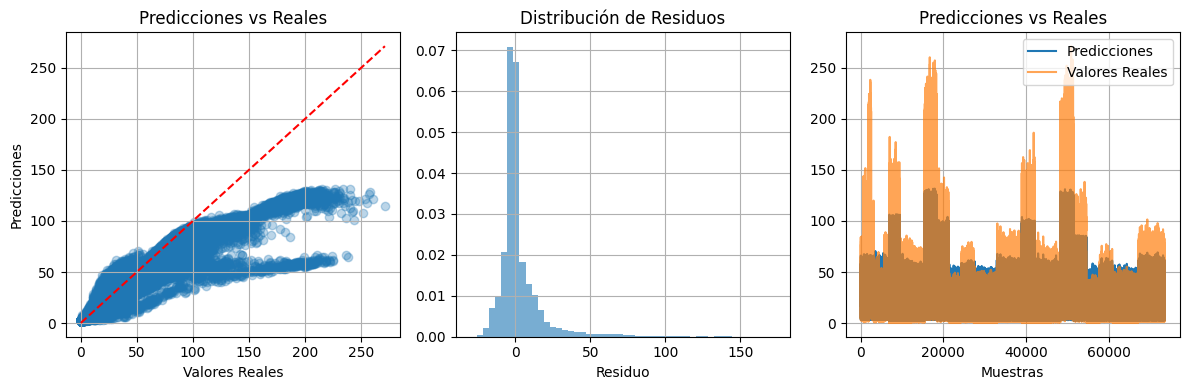

In [14]:
# Evaluación final del modelo global (o el mejor modelo guardado)
global_model.load_state_dict(torch.load(best_federated_model_path))
global_model.eval()
with torch.no_grad():
    y_pred = global_model(X_test_tensor).cpu().numpy()
    y_test_np = y_test_tensor.cpu().numpy()
    mse = mean_squared_error(y_test_np, y_pred)
    mae = mean_absolute_error(y_test_np, y_pred)
    r2 = r2_score(y_test_np, y_pred)
    print("\n=== Evaluación Final del Mejor Modelo Federado ===")
    print(f"Test MSE: {mse:.4f}")
    print(f"Test MAE: {mae:.4f}")
    print(f"Test R2: {r2:.4f}")

# (Opcional) Graficar resultados en Test
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.title('Predicciones vs Reales')
plt.scatter(y_test_np, y_pred, alpha=0.3)
plt.plot([y_test_np.min(), y_test_np.max()], [y_test_np.min(), y_test_np.max()], 'r--')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.grid(True)

plt.subplot(132)
residuals = y_test_np - y_pred
plt.hist(residuals, bins=50, density=True, alpha=0.6)
plt.title('Distribución de Residuos')
plt.xlabel('Residuo')
plt.grid(True)

plt.subplot(133)
plt.plot(y_pred, label="Predicciones")
plt.plot(y_test_np, label="Valores Reales", alpha=0.7)
plt.title('Predicciones vs Reales')
plt.xlabel('Muestras')
plt.legend() 
plt.grid(True)
plt.tight_layout()
plt.show()